## Inverse FFD

"Fitting mesh deformation to Free-Form Deformation (namely, inverse FFD)"  

### Requirements

- [numpy], [scipy]  
- [matplotlib]  
- **[libigl]**: Right now, I utilize this library for the following purposes.  
  + **igl.read_obj()**: load obj file  
  + **igl.extract_manifold_patches()**: separate to submeshes  
  + **igl.vertex_triangle_adjacency()**: get the faces that linked to vertex  

[numpy]:https://numpy.org/
[scipy]:https://www.scipy.org/
[matplotlib]:https://matplotlib.org/
[libigl]:https://libigl.github.io/libigl-python-bindings/

In [1]:
## load mesh data with libigl
import numpy as np
import igl

## load full mesh
x_full, u_full, _, tri_full, _, _ = igl.read_obj('data/4.obj')

x_full = x_full[:,:2] ## reduce vertex dimension: 3D -> 2D

In [2]:
selected = 3 ## [TEMPORARY]

## separate mesh
tri_subs = igl.extract_manifold_patches(tri_full)

## compute vertex to face correspondence in advance
v2f = igl.vertex_triangle_adjacency(tri_full, len(x_full))

<IPython.core.display.Javascript object>


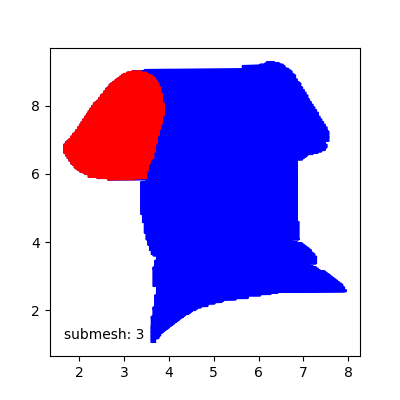

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax0 = plt.subplots(1, 1, figsize=(4,4))

line, = ax0.plot(x_full[:,0], x_full[:,1], c='b', picker=1)
text = ax0.text(np.min(x_full[:,0]), np.min(x_full[:,1]), "submesh: ", va="bottom", ha="left")

############################################################
## select submesh
############################################################
if False:
    def onpick(event):
        global selected

        if event.artist!=line: return True
        if not len(event.ind): return True

        ax0.plot(x_full[:,0], x_full[:,1], c='b')

        ## get the clicked point
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind

        ## get the submesh id
        selected = tri_subs[1][v2f[0][v2f[1][ind[0]]]]
        text.set_text('submesh: {0}'.format(selected)) ## show as text

        ## visualize the clicked submesh
        tri_sub  = tri_full[tri_subs[1]==selected]
        vidx_sub = np.unique(tri_sub.reshape(-1))
        x = x_full[vidx_sub]
        ax0.plot(x[:,0], x[:,1], c='r')

        return True

    fig.canvas.mpl_connect('pick_event', onpick)
    
else:
    text.set_text('submesh: {0}'.format(selected)) ## show as text

    ## visualize the clicked submesh
    tri_sub  = tri_full[tri_subs[1]==selected]
    vidx_sub = np.unique(tri_sub.reshape(-1))
    x = x_full[vidx_sub]
    ax0.plot(x[:,0], x[:,1], c='r')
    
plt.show()

In [4]:
## select the specific index from user-clicking point
tri_sub = tri_full[tri_subs[1]==selected]

## separate submesh from full mesh
vidx_sub = np.unique(tri_sub.reshape(-1))
x = x_full[vidx_sub]
u = u_full[vidx_sub]

## convert vertex indices for submesh
N = x.shape[0]
vidx = np.arange(0, x.shape[0])

vidx_full_to_sub = {}
for a,b in zip(vidx_sub, vidx):
    vidx_full_to_sub[a] = b

tri = [np.array([vidx_full_to_sub[v0],
                 vidx_full_to_sub[v1],
                 vidx_full_to_sub[v2]])
       for v0, v1, v2 in tri_sub]

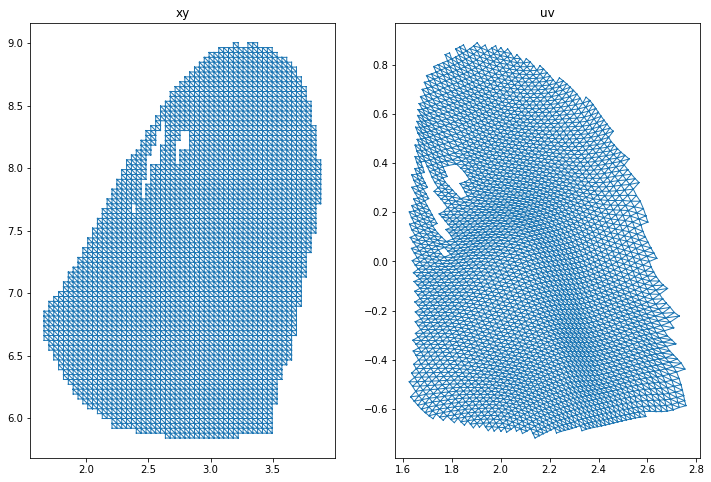

In [5]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

############################################################
## XY-space
############################################################
ax1.set_title('xy')

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1)

############################################################
## UV-space
############################################################
ax2.set_title('uv')

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1)

plt.show()

### Procedure

#### 1. Initialization: UV grid

1. Compute bounding box  
2. Subdivide UV grid  
3. Obtain grid points $B_{ij}$ on subdivided bounding box  


In [6]:
## compute bounding box
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

## small spacing for embedding vertices
eps = 2e-2

u_min = u_min - eps
u_max = u_max + eps
v_min = v_min - eps
v_max = v_max + eps

########################################
## compute visualization range
## suppose: vertical > horizontal
########################################
percentile = 0.05
aspect = (u_max-u_min) / (v_max-v_min)

## uv
eps = percentile * (v_max-v_min)
v_min_vis = v_min - eps
v_max_vis = v_max + eps
u_min_vis = (u_max+u_min)*0.5 - (v_max_vis-v_min_vis)*0.5
u_max_vis = (u_max+u_min)*0.5 + (v_max_vis-v_min_vis)*0.5

if aspect > 1.0:
    eps = percentile * (u_max-u_min)
    u_min_vis = u_min - eps
    u_max_vis = u_max + eps
    v_min_vis = (v_max+v_min)*0.5 - (u_max_vis-u_min_vis)*0.5
    v_max_vis = (v_max+v_min)*0.5 + (u_max_vis-u_min_vis)*0.5

print(u_min, v_min, u_max, v_max)

1.60583 -0.7389 2.77779 0.90979


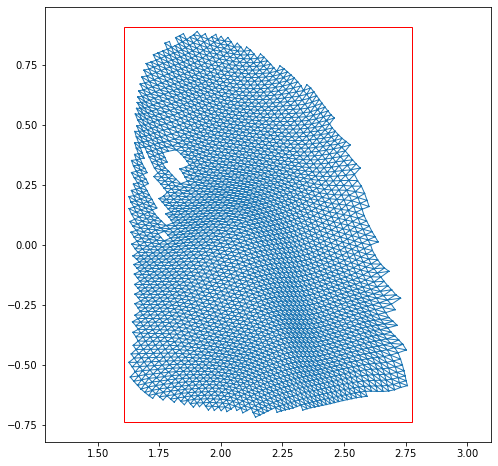

In [7]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])
ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

plt.show()

In [8]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

B_i = np.linspace(u_min, u_max, num=6)
B_j = np.linspace(v_min, v_max, num=8)

B_ix, B_jy = np.meshgrid(B_i, B_j)

def update(subdiv_u, subdiv_v):
    global B_i, B_j, B_ix, B_jy
    
    ## subdivide bounding box
    B_i = np.linspace(u_min, u_max, num=subdiv_u)
    B_j = np.linspace(v_min, v_max, num=subdiv_v)

    B_ix, B_jy = np.meshgrid(B_i, B_j)
    
    ## visualize bounding box
    from matplotlib.patches import Rectangle

    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xlim([u_min_vis, u_max_vis])
    ax.set_ylim([v_min_vis, v_max_vis])

    ax.triplot(u[:,0], u[:,1], tri)

    ## grid points
    ax.plot(B_ix, B_jy, 'o')

    ## draw lines between grid points
    for Bx in B_i:
        plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
    for By in B_j:
        plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

    plt.draw()

interact(update,
         subdiv_u = widgets.IntSlider(value=6, min=3, max=10),
         subdiv_v = widgets.IntSlider(value=8, min=4, max=12)
);

interactive(children=(IntSlider(value=6, description='subdiv_u', max=10, min=3), IntSlider(value=8, descriptio…

In [9]:
## get the grid points B_{ij}
B_ij = np.dstack((B_ix, B_jy)).reshape(-1,2)

#### 2. Construct least-squares problem



In [10]:
## construct sparse matrix
from scipy.sparse import dok_matrix

## allocate sparse matrix with additional rows for grid constraints
i = B_i.shape[0]
j = B_j.shape[0]
rows = 2*(x.shape[0] + (i-2)*j + i*(j-2) )
B_tilde = dok_matrix((rows, i*j*2), dtype=np.float32)

def ForEachUV(k, u_k, v_k):
    
    for i in range(len(B_i)-1):
        if (B_i[i] <= u_k and u_k <= B_i[i+1]):
            break
    
    for j in range(len(B_j)-1):
        if (B_j[j] <= v_k and v_k <= B_j[j+1]):
            break
    
    ## [CAUTION!] when (u_k, v_k) is near to (B_i[i], B_j[j]), weight becomes (1.0, 1.0)
    w_i = (B_i[i+1]-u_k) / (B_i[i+1]-B_i[i])
    w_j = (B_j[j+1]-v_k) / (B_j[j+1]-B_j[j])
    
    #print("{0},\t{1} \t-> ({2},{3}), weight = ({4},{5})".format(u_k, v_k, i, j, w_i, w_j))
    
    ## assign each elements into sparse matrix
    B_row = 2 * k

    B_col_i0j0 = 2 * ((i+0) + (j+0)*len(B_i) )
    B_col_i1j0 = 2 * ((i+1) + (j+0)*len(B_i) )
    B_col_i0j1 = 2 * ((i+0) + (j+1)*len(B_i) )
    B_col_i1j1 = 2 * ((i+1) + (j+1)*len(B_i) )
    
    B_tilde[B_row  , B_col_i0j0  ] = w_i*w_j
    B_tilde[B_row+1, B_col_i0j0+1] = w_i*w_j
    B_tilde[B_row  , B_col_i0j1  ] = w_i*(1.0-w_j)
    B_tilde[B_row+1, B_col_i0j1+1] = w_i*(1.0-w_j)
    
    B_tilde[B_row  , B_col_i1j0  ] = (1.0-w_i)*w_j
    B_tilde[B_row+1, B_col_i1j0+1] = (1.0-w_i)*w_j
    B_tilde[B_row  , B_col_i1j1  ] = (1.0-w_i)*(1.0-w_j)
    B_tilde[B_row+1, B_col_i1j1+1] = (1.0-w_i)*(1.0-w_j)
    
    return None

for k in range(len(u)):
    uv_k = u[k]
    ForEachUV(k, uv_k[0], uv_k[1])

############################################################
## additional constraints among grid points
############################################################
grid_weight = 0.2

## u-direction
cnt = 0
for i in range(1,len(B_i)-1):
    for j in range(len(B_j)):

        B_row = 2 * ( len(u) + cnt )
        B_col_i0j1 = 2 * ((i-1) + (j+0)*len(B_i) )
        B_col_i1j1 = 2 * ((i+0) + (j+0)*len(B_i) )
        B_col_i2j1 = 2 * ((i+1) + (j+0)*len(B_i) )
        
        B_tilde[B_row  , B_col_i0j1  ] = grid_weight
        B_tilde[B_row+1, B_col_i0j1+1] = grid_weight
        B_tilde[B_row  , B_col_i1j1  ] = -2.0 * grid_weight
        B_tilde[B_row+1, B_col_i1j1+1] = -2.0 * grid_weight
        B_tilde[B_row  , B_col_i2j1  ] = grid_weight
        B_tilde[B_row+1, B_col_i2j1+1] = grid_weight
        
        cnt+=1

## v-direction
cnt = 0
for i in range(len(B_i)):
    for j in range(1,len(B_j)-1):

        B_row = 2 * ( len(u) + (len(B_i)-2)*len(B_j) + cnt )
        B_col_i1j0 = 2 * ((i+0) + (j-1)*len(B_i) )
        B_col_i1j1 = 2 * ((i+0) + (j+0)*len(B_i) )
        B_col_i1j2 = 2 * ((i+0) + (j+1)*len(B_i) )
        
        B_tilde[B_row  , B_col_i1j0  ] = grid_weight
        B_tilde[B_row+1, B_col_i1j0+1] = grid_weight
        B_tilde[B_row  , B_col_i1j1  ] = -2.0 * grid_weight
        B_tilde[B_row+1, B_col_i1j1+1] = -2.0 * grid_weight
        B_tilde[B_row  , B_col_i1j2  ] = grid_weight
        B_tilde[B_row+1, B_col_i1j2+1] = grid_weight
        
        cnt+=1


In [11]:
## constant part: make it as 1-dim vector + concat zero-vector
i = B_i.shape[0]
j = B_j.shape[0]
x_tilde = np.concatenate([x.reshape(-1), np.zeros([2*( (i-2)*j + i*(j-2) )])])

#### 3. Solve least-squares problem

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html  

In [12]:
## solve Least-Squares problem with scipy.sparse:
from datetime import datetime
from scipy.sparse.linalg import lsqr

print("try to solve LS...")

start = datetime.now()

P_tilde, isstop, itn, r1norm = lsqr(B_tilde, x_tilde)[:4]

end = datetime.now()

print(isstop, itn, r1norm)
print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

try to solve LS...
2 73 0.7404917752799115
elapsed time: 11.733465 [sec]


In [13]:
## revert to the original 2-dimensional vector
P = P_tilde.reshape(-1,2)

## prepare data for visualization
P_i, P_j = P.T
P_ix = P_i.reshape(len(B_j), len(B_i))
P_jy = P_j.reshape(len(B_j), len(B_i))

In [14]:
## compute xy visualization range
x_min, x_max = np.min(P[:,0]), np.max(P[:,0])
y_min, y_max = np.min(P[:,1]), np.max(P[:,1])

eps = percentile * (y_max-y_min)
y_min_vis = y_min - eps
y_max_vis = y_max + eps
x_min_vis = (x_max+x_min)*0.5 - (y_max_vis-y_min_vis)*0.5
x_max_vis = (x_max+x_min)*0.5 + (y_max_vis-y_min_vis)*0.5

aspect = (x_max-x_min) / (y_max-y_min)

if aspect > 1.0:
    eps = percentile * (x_max-x_min)
    x_min_vis = x_min - eps
    x_max_vis = x_max + eps
    y_min_vis = (y_max+y_min)*0.5 - (x_max_vis-x_min_vis)*0.5
    y_max_vis = (y_max+y_min)*0.5 + (x_max_vis-x_min_vis)*0.5

print(x_min, y_min, x_max, y_max)

1.4675649957959684 5.656564875070103 4.584889743170806 9.201077630110685


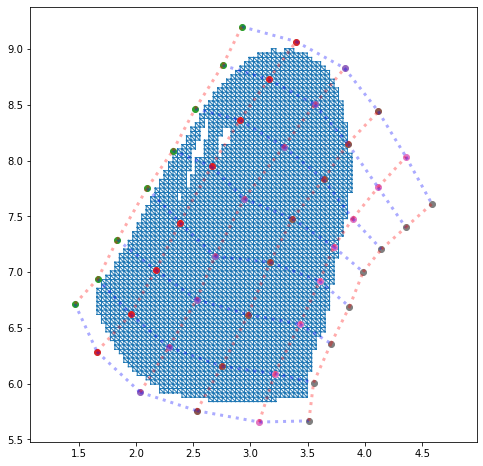

In [15]:
%matplotlib inline

## visualize control points in X-space
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([x_min_vis,x_max_vis])
ax.set_ylim([y_min_vis,y_max_vis])

ax.triplot(x[:,0], x[:,1], tri, linewidth=1.0)

## grid points
ax.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':', linewidth=3.0)

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':', linewidth=3.0)

plt.show()

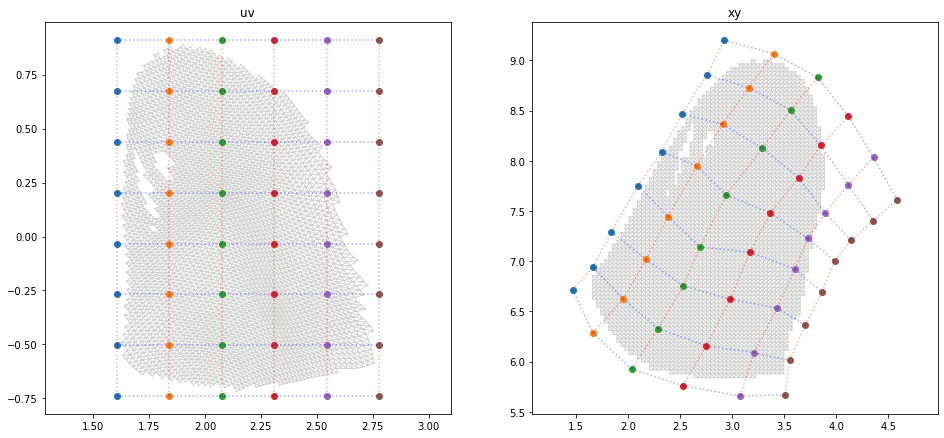

In [16]:
## visualize mesh data by Matplotlib
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16,7.2))

########################################
## XY space
########################################
ax1.set_xlim([x_min_vis,x_max_vis])
ax1.set_ylim([y_min_vis,y_max_vis])

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

########################################
## UV space
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

ax1.set_title('xy')
ax2.set_title('uv')

plt.show()

#### 4. Editing UV grid

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

class DraggablePoints(object):
    def __init__(self, artists, tolerance=5):
        for artist in artists:
            artist.set_picker(tolerance)
        self.artists = artists
        self.currently_dragging = False
        self.current_artist = None
        self.offset = (0, 0)

        for canvas in set(artist.figure.canvas for artist in self.artists):
            canvas.mpl_connect('button_press_event', self.on_press)
            canvas.mpl_connect('button_release_event', self.on_release)
            canvas.mpl_connect('pick_event', self.on_pick)
            canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        self.currently_dragging = True
    def on_release(self, event):
        self.currently_dragging = False
        self.current_artist = None

    def on_pick(self, event):
        if self.current_artist is None:
            self.current_artist = event.artist
            x0, y0 = event.artist.center
            x1, y1 = event.mouseevent.xdata, event.mouseevent.ydata
            self.offset = (x0 - x1), (y0 - y1)

    def on_motion(self, event):
        if not self.currently_dragging:
            return
        if self.current_artist is None:
            return
        dx, dy = self.offset
        self.current_artist.center = event.xdata + dx, event.ydata + dy
        self.current_artist.figure.canvas.draw()


<IPython.core.display.Javascript object>


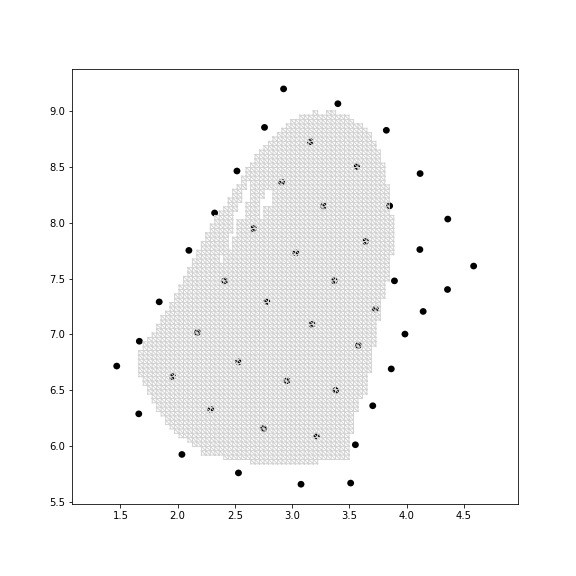

In [19]:
%matplotlib notebook

## visualize control points in X-space
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([x_min_vis,x_max_vis])
ax.set_ylim([y_min_vis,y_max_vis])

ax.triplot(x[:,0], x[:,1], tri, linewidth=1.0, c='lightgray')

## grid points
circles = [patches.Circle((P_i, P_j), 0.03, fc='k') for P_i, P_j in zip(P_ix.reshape(-1), P_jy.reshape(-1))]
for circ in circles:
    ax.add_patch(circ)

dr = DraggablePoints(circles)

plt.show()

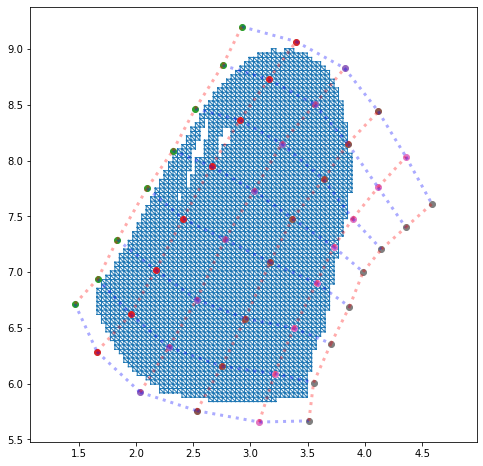

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

## transfer modified data from matplotlib
P_ix = []
P_jy = []

for j in range(len(B_j)):
    for i in range(len(B_i)):
        center = circles[i+j*len(B_i)].center
        P_ix.append(center[0])
        P_jy.append(center[1])

P_ix = np.array(P_ix).reshape(-1,len(B_i))
P_jy = np.array(P_jy).reshape(-1,len(B_i))

if True:
    ## visualize control points in X-space
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xlim([x_min_vis,x_max_vis])
    ax.set_ylim([y_min_vis,y_max_vis])

    ax.triplot(x[:,0], x[:,1], tri, linewidth=1.0)

    ## grid points
    ax.plot(P_ix, P_jy, 'o')

    ## draw lines
    for j in range(P_ix.shape[0]):
        for i in range(P_ix.shape[1]-1):
            plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':', linewidth=3.0)

    for i in range(P_ix.shape[1]):
        for j in range(P_ix.shape[0]-1):
            plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':', linewidth=3.0)

    plt.show()

#### 4. Free-Form Deformation of UV

- バーンスタイン多項式(Bernstein polynomial)によって求まる．  
  $$\mathbf{X} = (1-u)(1-v) \cdot \mathbf{X}_{0,0} + u(1-v) \cdot \mathbf{X}_{1,0} + (1-u)v \cdot \mathbf{X}_{0,1} + uv \cdot \mathbf{X}_{1,1} $$
  この式において，$u$ と $v$ を求めれば良い．  
- 1次バーンスタイン多項式の場合，式はやや複雑だが，書き下せば $u$, $v$ が解析的に求まるので今回はこちらを利用した．  
  但し，もっと高次のバーンスタイン多項式は，恐らく，解析的に求まりづらいと思われる．  

In [21]:
## get uv from 2-dimensional grid
def GetUV_Grid(x00, y00, x10, y10, x01, y01, x11, y11, x, y):
    ax =  x00 - x10 - x01 + x11
    ay =  y00 - y10 - y01 + y11
    bx = -x00 + x10
    by = -y00 + y10
    cx = -x00 + x01
    cy = -y00 + y01
    dx = -x00 + x
    dy = -y00 + y
    
    A1 = (ay*bx - ax*by)
    B1 = (ay*dx - ax*dy + by*cx - bx*cy)
    C1 = (cx*dy - cy*dx)
    
    A2 = (ay*cx - ax*cy)
    B2 = (ay*dx - ax*dy + bx*cy - by*cx)
    C2 = (bx*dy - by*dx)
    
    u = (B1 + np.sqrt(B1*B1 - 4.0*A1*C1)) / (2.0 * A1) if np.abs(A1) > 1e-8 else C1/B1
    v = (B2 - np.sqrt(B2*B2 - 4.0*A2*C2)) / (2.0 * A2) if np.abs(A2) > 1e-8 else C2/B2
    
    return np.array([u,v])

if False:
    _u,_v = GetUV_Grid(0.0, 0.0,
                       2.0, 0.0,
                       0.0, 2.0,
                       4.0, 2.0,
                       0.0, 0.0)
    print(_u,_v)

In [22]:
def lineDet(x1, y1, x2, y2, x, y):
    a = y2-y1
    b = x2-x1
    c = -a*x1 + b*y1
    
    return a*x - b*y + c >= 0
    
def gridDet(P00_x, P00_y, P01_x, P01_y, P10_x, P10_y, P11_x, P11_y, x, y):
    b_P00_P01 = lineDet(P00_x, P00_y, P01_x, P01_y, x, y)
    b_P10_P11 = lineDet(P10_x, P10_y, P11_x, P11_y, x, y)
    b_P00_P10 = lineDet(P00_x, P00_y, P10_x, P10_y, x, y)
    b_P01_P11 = lineDet(P01_x, P01_y, P11_x, P11_y, x, y)
    
    return np.logical_and( 
        np.logical_xor(b_P00_P01, b_P10_P11),
        np.logical_xor(b_P00_P10, b_P01_P11) )

## checking
if False:
    for j in range(P_ix.shape[1]-1):
        for i in range(P_ix.shape[0]-1):
            res = gridDet(P_ix[i  ][j], P_jy[i  ][j], P_ix[i  ][j+1], P_jy[i  ][j+1],
                          P_ix[i+1][j], P_jy[i+1][j], P_ix[i+1][j+1], P_jy[i+1][j+1],
                          x[:,0], x[:,1])
            x_in = x[res]

            fig, ax1 = plt.subplots(1, 1, figsize=(8,7.2))

            ########################################
            ## XY space
            ########################################
            ax1.set_xlim([x_min_vis,x_max_vis])
            ax1.set_ylim([y_min_vis,y_max_vis])

            ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='lightgray')

            ax1.plot(x_in[:,0], x_in[:,1], 'o', c='black')

            ## grid points
            ax1.plot(P_ix[i  ][j:j+2], P_jy[i  ][j:j+2], 'o')
            ax1.plot(P_ix[i+1][j:j+2], P_jy[i+1][j:j+2], 'o')

            plt.show()

In [23]:
def GetIndex(x_k, y_k):
    for i in range(P_ix.shape[0]-1):
        for j in range(P_ix.shape[1]-1):
            if gridDet(P_ix[i  ][j], P_jy[i  ][j], P_ix[i  ][j+1], P_jy[i  ][j+1],
                       P_ix[i+1][j], P_jy[i+1][j], P_ix[i+1][j+1], P_jy[i+1][j+1],
                       x_k, y_k): return i,j
    print(x_k, y_k)
    return -1,-1

def GetWeight(x_k, y_k, i,j):
    x00 = P_ix[i  ][j  ]
    y00 = P_jy[i  ][j  ]
    x10 = P_ix[i  ][j+1]
    y10 = P_jy[i  ][j+1]
    x01 = P_ix[i+1][j  ]
    y01 = P_jy[i+1][j  ]
    x11 = P_ix[i+1][j+1]
    y11 = P_jy[i+1][j+1]
    
    _u, _v = GetUV_Grid(x00, y00, x10, y10, x01, y01, x11, y11, x_k, y_k)
    
    return np.array([_u,_v])

def GetIndexAndWeight(x_k, y_k):
    i, j = GetIndex(x_k, y_k)
    
    w_i, w_j = GetWeight(x_k, y_k, i, j)
    
    return (j,i), (w_i,w_j)

In [24]:
u_grid = u.copy()

for k in range(len(x)):
    x_k = x[k]
    
    (j,i), (w_j,w_i) = GetIndexAndWeight(x_k[0], x_k[1])
    
    ## [CAUTION]
    w_i = 1.0 - w_i
    w_j = 1.0 - w_j
    
    B00 = np.array([B_ix[i  ,j  ], B_jy[i  ,j  ]])
    B01 = np.array([B_ix[i  ,j+1], B_jy[i  ,j+1]])
    B10 = np.array([B_ix[i+1,j  ], B_jy[i+1,j  ]])
    B11 = np.array([B_ix[i+1,j+1], B_jy[i+1,j+1]])
    
    u_grid[k] = (B00 *      w_i *      w_j  +
                 B01 *      w_i * (1.0-w_j) +
                 B10 * (1.0-w_i)*      w_j  +
                 B11 * (1.0-w_i)* (1.0-w_j) )

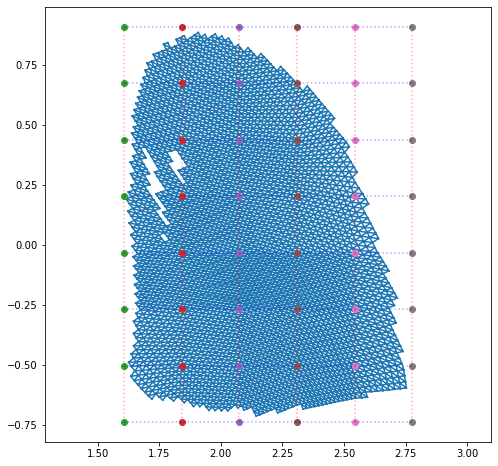

In [25]:
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])

ax.triplot(u_grid[:,0], u_grid[:,1], tri)

## grid points
ax.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

plt.draw()

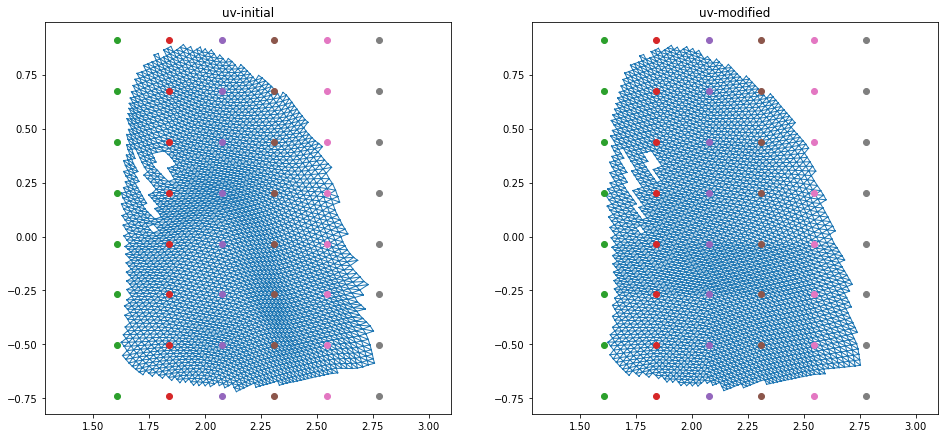

In [26]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7.2))

########################################
## XY space
########################################
ax1.set_xlim([u_min_vis, u_max_vis])
ax1.set_ylim([v_min_vis, v_max_vis])

ax1.triplot(u[:,0], u[:,1], tri, linewidth=1)#, color='lightgray')

## grid points
ax1.plot(B_ix, B_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

########################################
## UV space
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(u_grid[:,0], u_grid[:,1], tri, linewidth=1)#, color='lightgray')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax2.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax2.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax1.set_title('uv-initial')
ax2.set_title('uv-modified')

plt.show()

In [27]:
def GetCubicBezier(P0, P1, P2, P3, t):
    t1 = (1-t)
    return t1*t1*t1*P0 + 3.0*t1*t1*t*P1 + 3.0*t1*t*t*P2 + t*t*t*P3
    
def GetDerivCubicBezier(P0m, P0, P1, P1p, t):
    C = 1.0/3.0 ## arbitrary constant value
    
    _P1 = P0 + C*(P0 - P0m)
    _P2 = P1 + C*(P1 - P1p)
    
    return GetCubicBezier(P0, _P1, _P2, P1, t)

if False:
    X10 = np.array([1.4, 0.0])
    X20 = np.array([1.6, 0.0])

    X01 = np.array([0.0, 1.4])
    X11 = np.array([1.0, 1.0])
    X21 = np.array([2.0, 1.0])
    X31 = np.array([3.0, 1.4])

    X02 = np.array([0.0, 1.6])
    X12 = np.array([1.0, 2.0])
    X22 = np.array([2.0, 2.0])
    X32 = np.array([3.0, 1.6])

    X13 = np.array([1.4, 3.0])
    X23 = np.array([1.6, 3.0])
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))

    ax.set_xlim([-0.05,3.05])
    ax.set_ylim([-0.05,3.05])

    ax.plot(X10[0], X10[1], 'o', color='k')
    ax.plot(X20[0], X20[1], 'o', color='k')

    ax.plot(X01[0], X01[1], 'o', color='k')
    ax.plot(X11[0], X11[1], 'o', color='k')
    ax.plot(X21[0], X21[1], 'o', color='k')
    ax.plot(X31[0], X31[1], 'o', color='k')

    ax.plot(X02[0], X02[1], 'o', color='k')
    ax.plot(X12[0], X12[1], 'o', color='k')
    ax.plot(X22[0], X22[1], 'o', color='k')
    ax.plot(X32[0], X32[1], 'o', color='k')

    ax.plot(X23[0], X23[1], 'o', color='k')
    ax.plot(X23[0], X23[1], 'o', color='k')
    
    for t in np.linspace(0,1,26):
        _P = GetDerivCubicBezier(X01, X11, X21, X31, t)
        ax.plot(_P[0], _P[1], '.', color=(1,0,0))

        _P = GetDerivCubicBezier(X02, X12, X22, X32, t)
        ax.plot(_P[0], _P[1], '.', color=(1,0,0))
        
        _P = GetDerivCubicBezier(X10, X11, X12, X13, t)
        ax.plot(_P[0], _P[1], '.', color=(0,0,1))
        
        _P = GetDerivCubicBezier(X20, X21, X22, X23, t)
        ax.plot(_P[0], _P[1], '.', color=(0,0,1))
        

In [28]:
eps = 0.075

## Free-form deformation
def GetU_FFD(GridLine0, GridLine1, x_ffd, y_ffd, num_iter=30):
    
    u_ffd, v_ffd = GetUV_Grid(GridLine0[1][0],GridLine0[1][1],GridLine1[1][0],GridLine1[1][1],
                              GridLine0[2][0],GridLine0[2][1],GridLine1[2][0],GridLine1[2][1], x_ffd, y_ffd)
    
    ## minimum value for binary search
    u_min = 0.0 - eps
    X0 = (1.0-u_min) * GridLine0[0] + u_min * GridLine1[0]
    X1 = (1.0-u_min) * GridLine0[1] + u_min * GridLine1[1]
    X2 = (1.0-u_min) * GridLine0[2] + u_min * GridLine1[2]
    X3 = (1.0-u_min) * GridLine0[3] + u_min * GridLine1[3]
    x_cubic, y_cubic = GetDerivCubicBezier(X0, X1, X2, X3, v_ffd)
    
    if x_cubic > x_ffd:
        print("something is wrong: u_min")
        return u_min
    
    ## maximum value for binary search
    u_max = 1.0 + eps
    X0 = (1.0-u_max) * GridLine0[0] + u_max * GridLine1[0]
    X1 = (1.0-u_max) * GridLine0[1] + u_max * GridLine1[1]
    X2 = (1.0-u_max) * GridLine0[2] + u_max * GridLine1[2]
    X3 = (1.0-u_max) * GridLine0[3] + u_max * GridLine1[3]
    x_cubic, y_cubic = GetDerivCubicBezier(X0, X1, X2, X3, v_ffd)
    
    if x_cubic < x_ffd:
        print("something is wrong: u_max")
        return u_max
    
    ## binary search
    for it in range(num_iter):
        u_mid = 0.5 * (u_min + u_max)
        
        X0 = (1.0-u_mid) * GridLine0[0] + u_mid * GridLine1[0]
        X1 = (1.0-u_mid) * GridLine0[1] + u_mid * GridLine1[1]
        X2 = (1.0-u_mid) * GridLine0[2] + u_mid * GridLine1[2]
        X3 = (1.0-u_mid) * GridLine0[3] + u_mid * GridLine1[3]
        
        x_cubic, _ = GetDerivCubicBezier(X0, X1, X2, X3, v_ffd)

        if np.abs(x_cubic - x_ffd) < 1e-6: return u_mid
        
        if x_cubic > x_ffd:
            u_max = u_mid
        else:
            u_min = u_mid
        
    return u_mid

def GetV_FFD(GridLine0, GridLine1, x_ffd, y_ffd, num_iter=30):
    
    u_ffd, v_ffd = GetUV_Grid(GridLine0[1][0],GridLine0[1][1],GridLine0[2][0],GridLine0[2][1],
                              GridLine1[1][0],GridLine1[1][1],GridLine1[2][0],GridLine1[2][1], x_ffd, y_ffd)
    
    ## minimum value for binary search
    v_min = 0.0 - eps
    X0 = (1.0-v_min) * GridLine0[0] + v_min * GridLine1[0]
    X1 = (1.0-v_min) * GridLine0[1] + v_min * GridLine1[1]
    X2 = (1.0-v_min) * GridLine0[2] + v_min * GridLine1[2]
    X3 = (1.0-v_min) * GridLine0[3] + v_min * GridLine1[3]
    x_cubic, y_cubic = GetDerivCubicBezier(X0, X1, X2, X3, u_ffd)
    
    if y_cubic > y_ffd:
        print("something is wrong: v_max")
        return v_min
    
    ## maximum value for binary search
    v_max = 1.0 + eps
    X0 = (1.0-v_max) * GridLine0[0] + v_max * GridLine1[0]
    X1 = (1.0-v_max) * GridLine0[1] + v_max * GridLine1[1]
    X2 = (1.0-v_max) * GridLine0[2] + v_max * GridLine1[2]
    X3 = (1.0-v_max) * GridLine0[3] + v_max * GridLine1[3]
    x_cubic, y_cubic = GetDerivCubicBezier(X0, X1, X2, X3, u_ffd)
    
    if y_cubic < y_ffd:
        print("something is wrong: v_max")
        return v_max
    
    ## binary search
    for it in range(num_iter):
        v_mid = 0.5 * (v_min + v_max)
        
        X0 = (1.0-v_mid) * GridLine0[0] + v_mid * GridLine1[0]
        X1 = (1.0-v_mid) * GridLine0[1] + v_mid * GridLine1[1]
        X2 = (1.0-v_mid) * GridLine0[2] + v_mid * GridLine1[2]
        X3 = (1.0-v_mid) * GridLine0[3] + v_mid * GridLine1[3]
        
        _, y_cubic = GetDerivCubicBezier(X0, X1, X2, X3, u_ffd)
        
        if np.abs(y_cubic - y_ffd) < 1e-6: return v_mid
        
        if y_cubic > y_ffd:
            v_max = v_mid
        else:
            v_min = v_mid
        
    return v_mid


In [30]:
u_ffd = u.copy()

cnt = 0

for k in range(len(x)):
    x_k = x[k]
    i,j = GetIndex(x_k[0], x_k[1])
    
    P11 = np.array([P_ix[i  ,j  ], P_jy[i  ,j  ]])
    P12 = np.array([P_ix[i+1,j  ], P_jy[i+1,j  ]])
    P21 = np.array([P_ix[i  ,j+1], P_jy[i  ,j+1]])
    P22 = np.array([P_ix[i+1,j+1], P_jy[i+1,j+1]])
    
    ## [TEMPORARY]
    _u, _v = GetUV_Grid(P11[0],P11[1],P21[0],P21[1],
                        P12[0],P12[1],P22[0],P22[1], x_k[0], x_k[1])
    
    ############################################################
    ## check outside of X-grid
    ############################################################
    if j-1 >= 0:
        P01 = np.array([P_ix[i  ,j-1], P_jy[i  ,j-1]])
        P02 = np.array([P_ix[i+1,j-1], P_jy[i+1,j-1]])
    else:
        P01 = 2.0*P11 - P21
        P02 = 2.0*P12 - P22
    
    if j+2 < P_ix.shape[1]:
        P31 = np.array([P_ix[i  ,j+2], P_jy[i  ,j+2]])
        P32 = np.array([P_ix[i+1,j+2], P_jy[i+1,j+2]])
    else:
        P31 = 2.0*P21 - P11
        P32 = 2.0*P22 - P12
    
    _v = GetV_FFD(np.array([P01,P11,P21,P31]), np.array([P02,P12,P22,P32]), x_k[0], x_k[1])
    
    ############################################################
    ## check outside of Y-grid
    ############################################################
    if i-1 >= 0:
        P10 = np.array([P_ix[i-1,j  ], P_jy[i-1,j  ]])
        P20 = np.array([P_ix[i-1,j+1], P_jy[i-1,j+1]])
    else:
        P10 = 2.0*P11 - P12
        P20 = 2.0*P21 - P22
    
    if i+2 < P_jy.shape[0]:
        P13 = np.array([P_ix[i+2,j  ], P_jy[i+2,j  ]])
        P23 = np.array([P_ix[i+2,j+1], P_jy[i+2,j+1]])
    else:
        P13 = 2.0*P12 - P11
        P23 = 2.0*P22 - P21
    
    _u = GetU_FFD(np.array([P10,P11,P12,P13]), np.array([P20,P21,P22,P23]), x_k[0], x_k[1])
    
    ## [CAUTION] when it appears P00, weight should be (1.0, 1.0)
    w_i = 1.0 - _u
    w_j = 1.0 - _v
    
    ## revert to UV space ...
    B00 = np.array([B_ix[i  ,j  ], B_jy[i  ,j  ]])
    B10 = np.array([B_ix[i  ,j+1], B_jy[i  ,j+1]])
    B01 = np.array([B_ix[i+1,j  ], B_jy[i+1,j  ]])
    B11 = np.array([B_ix[i+1,j+1], B_jy[i+1,j+1]])
    
    u_ffd[k] = (B00 *      w_i *      w_j  +
                B01 *      w_i * (1.0-w_j) +
                B10 * (1.0-w_i)*      w_j  +
                B11 * (1.0-w_i)* (1.0-w_j) )

    ## [TEMPORARY]
    cnt = cnt + 1
    if cnt == 300 and False:
        
        ## quick visualization
        fig, ax1 = plt.subplots(1, 1, figsize=(8,7.2))

        ########################################
        ## XY space
        ########################################
        ax1.set_xlim([x_min_vis,x_max_vis])
        ax1.set_ylim([y_min_vis,y_max_vis])

        ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='lightgray')

        ax1.plot(x_k[0], x_k[1], '.', c='black')

        ## grid points
        ax1.plot(np.array([P01,P11,P21,P31])[:,0], np.array([P01,P11,P21,P31])[:,1], 'o')
        ax1.plot(np.array([P02,P12,P22,P32])[:,0], np.array([P02,P12,P22,P32])[:,1], 'o')
        
        ax1.plot(np.array([P10,P11,P12,P13])[:,0], np.array([P10,P11,P12,P13])[:,1], '.')
        ax1.plot(np.array([P20,P21,P22,P23])[:,0], np.array([P20,P21,P22,P23])[:,1], '.')
        
        ## curve to show u- and v- coordinate
        N = 20
        for i in range(N):
            X0 = (1.0-_v) * P01 + _v * P02
            X1 = (1.0-_v) * P11 + _v * P12
            X2 = (1.0-_v) * P21 + _v * P22
            X3 = (1.0-_v) * P31 + _v * P32
            
            t0 = i/N
            t1 = (i+1)/N
            xc0, yc0 = GetDerivCubicBezier(X0, X1, X2, X3, t0)
            xc1, yc1 = GetDerivCubicBezier(X0, X1, X2, X3, t1)
            
            ax1.plot(np.array([xc0, xc1]), np.array([yc0, yc1]), color='black', linestyle='-')
        
        for i in range(N):
            X0 = (1.0-_u) * P10 + _u * P20
            X1 = (1.0-_u) * P11 + _u * P21
            X2 = (1.0-_u) * P12 + _u * P22
            X3 = (1.0-_u) * P13 + _u * P23
            
            t0 = i/N
            t1 = (i+1)/N
            xc0, yc0 = GetDerivCubicBezier(X0, X1, X2, X3, t0)
            xc1, yc1 = GetDerivCubicBezier(X0, X1, X2, X3, t1)
            
            ax1.plot(np.array([xc0, xc1]), np.array([yc0, yc1]), color='black', linestyle='-')
        
        plt.show()
        
        cnt = 0
    
print('DONE')

DONE


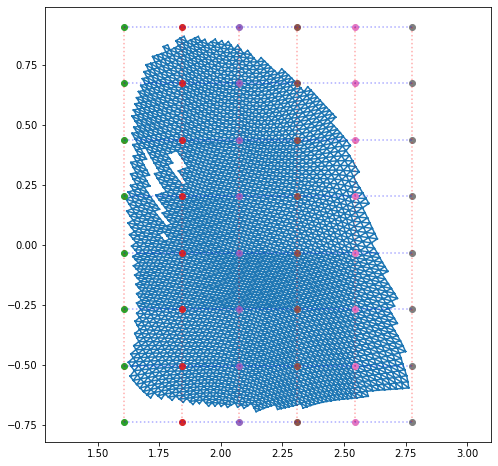

In [31]:
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])

ax.triplot(u_ffd[:,0], u_ffd[:,1], tri)

## grid points
ax.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

plt.draw()

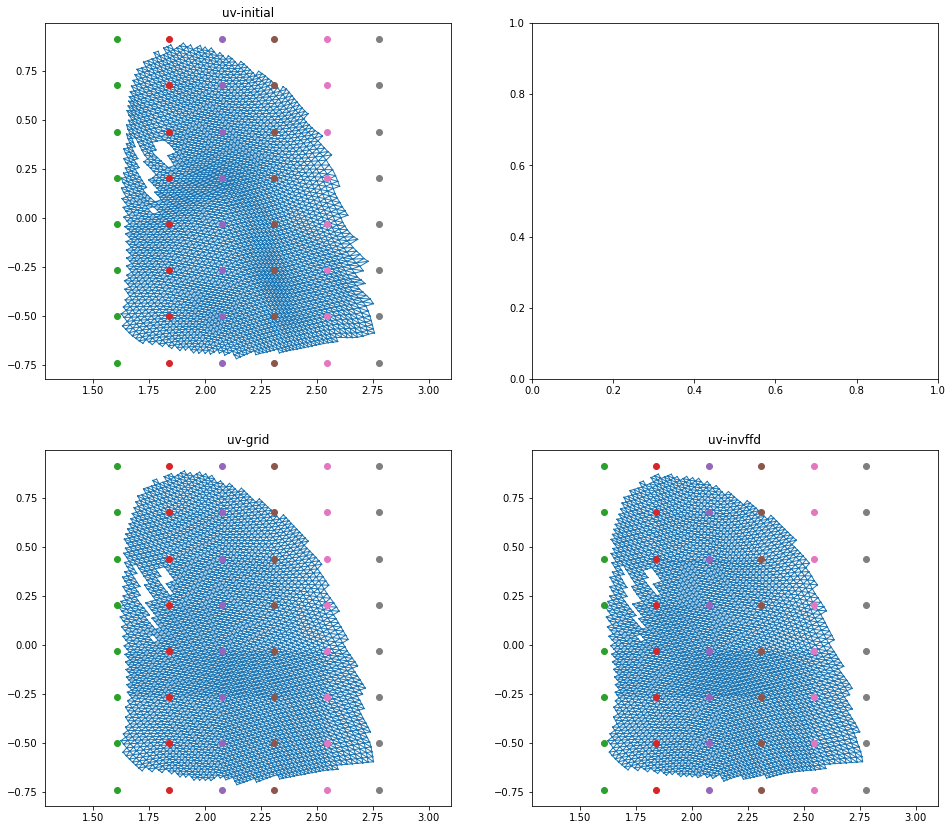

In [32]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, ((ax0, _), (ax1, ax2)) = plt.subplots(2, 2, figsize=(16,14.4))

########################################
## XY space
########################################
ax0.set_xlim([u_min_vis, u_max_vis])
ax0.set_ylim([v_min_vis, v_max_vis])

ax0.triplot(u[:,0], u[:,1], tri, linewidth=1)#, color='lightgray')

## grid points
ax0.plot(B_ix, B_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax0.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax0.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax0.set_title('uv-initial')

########################################
## UV space
########################################
ax1.set_xlim([u_min_vis, u_max_vis])
ax1.set_ylim([v_min_vis, v_max_vis])

ax1.triplot(u_grid[:,0], u_grid[:,1], tri, linewidth=1)#, color='lightgray')

## grid points
ax1.plot(B_ix, B_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax1.set_title('uv-grid')

########################################
## UV space
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(u_ffd[:,0], u_ffd[:,1], tri, linewidth=1)#, color='lightgray')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax2.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax2.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax2.set_title('uv-invffd')

plt.show()

In [34]:
## export to obj file...

with open('data/transformed.obj', 'w') as f:
    f.write('mtllib redtartan.mtl\n')
    
    for _v in x:
        f.write('v {0} {1} 0\n'.format(_v[0], _v[1]))
    
    #for _vt in u_grid:
    for _vt in u_ffd:
        f.write('vt {0} {1}\n'.format(_vt[0], _vt[1]))

    for _tri in tri:
        f.write('f {0}/{0} {1}/{1} {2}/{2}\n'.format(_tri[0]+1, _tri[1]+1, _tri[2]+1))


(end)